In [306]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [307]:
WANDB_RUN_NAME = f"BioMedBERT-Abstract-Weighted"

# Setup

In [308]:
import re
import os
import ast
import json
import wandb
import unicodedata
import pandas as pd
from pathlib import Path
import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

import torch
import torch.nn as nn
import flash_attn
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import EarlyStoppingCallback
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline

import sys
sys.path.append("../../src")
sys.path.append("../../configs")
import util.preprocessing_util as util
from hf_config import hf_token

**Check versions of important packages**

In [309]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Flash Attention version:", flash_attn.__version__)

PyTorch version: 2.6.0+cu124
CUDA version: 12.4
Flash Attention version: 2.7.4.post1


**Check which python we are using**

In [310]:
print(sys.executable)

/share/miniforge3/bin/python3.10


In [311]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Load the data**

In [312]:
DATA_DIR = Path("../../data")
SYNTHETIC_TRAIN_DATA_DIR = DATA_DIR / "synthetic" / "questions"
TEST_DATA_DIR = DATA_DIR / "dev" / "processed"

TRAIN_DATA_FILE_NAME = "real-notes-6-qs.csv"
TEST_DATA_FILE_NAME = "medical_data.csv"

MODELS_DIR = Path("../../models/")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

In [313]:
train_data = pd.read_csv(SYNTHETIC_TRAIN_DATA_DIR / TRAIN_DATA_FILE_NAME)
test_data = pd.read_csv(TEST_DATA_DIR / TEST_DATA_FILE_NAME)

Sentences and labels are still stringified lists --> back to actual Python lists

In [314]:
train_data["sentences"] = train_data["sentences"].apply(ast.literal_eval)
train_data["labels"] = train_data["labels"].apply(ast.literal_eval)

test_data["sentences"] = test_data["sentences"].apply(ast.literal_eval)
test_data["labels"] = test_data["labels"].apply(ast.literal_eval)

**TO BE REMOVED LATER - WE ALREADY DO THIS IN Q-GENERATION**

In [315]:
train_data = train_data[[
    "patient_question",
    "clinician_question",
    "sentences",
    "note_excerpt",
    "labels"
]]

# Exploration

In [316]:
train_data.head(3)

,patient_question,clinician_question,sentences,note_excerpt,labels
0,"Why did I need a stent for my bile duct, and w...",What findings were observed during the ERCP re...,"[Brief Hospital Course:, During the ERCP a pan...",Brief Hospital Course: During the ERCP a pancr...,"[0, 1, 0, 1, 0, 1, 1, 1, 0]"
1,Why did I need another procedure after the fir...,What were the reasons for the re-evaluation of...,"[Brief Hospital Course:, During the ERCP a pan...",Brief Hospital Course: During the ERCP a pancr...,"[0, 1, 1, 1, 0, 1, 1, 1, 0]"
2,Why did I need a stent placed in my bile duct?,What was the indication for placing a stent in...,"[Brief Hospital Course:, During the ERCP a pan...",Brief Hospital Course: During the ERCP a pancr...,"[0, 1, 1, 0, 0, 0, 0, 0, 0]"


In [317]:
test_data.head(3)

,case_id,patient_question,clinician_question,note_excerpt,sentences,sentence_text,labels
0,1,My question is if the sludge was there does no...,Why was ERCP recommended to him over continuin...,Brief Hospital Course: During the ERCP a pancr...,"[Brief Hospital Course:, During the ERCP a pan...",Brief Hospital Course:,"[0, 1, 0, 0, 0, 1, 1, 1, 0]"
1,2,dad given multiple shots of lasciks after he w...,Why was he given lasix and his oxygen flow rat...,Brief Hospital Course: Acute diastolic heart f...,"[Brief Hospital Course:, Acute diastolic heart...",Brief Hospital Course:,"[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]"
2,3,he is continously irritated and has headache w...,What is the expected course of recovery for him?,Discharge Instructions: You were admitted to t...,[Discharge Instructions: You were admitted to ...,Discharge Instructions: You were admitted to t...,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0]"


# Masking

We’ll create one row per sentence: full context + label for only that sentence

And add **[START]** and **[END]** markers around the target sentence

In [318]:
WINDOW_SIZE = 1

In [319]:
train_data_masked = util.mask_on_sentence_level(train_data, window=WINDOW_SIZE, use_clinician_question = True)
test_data_masked = util.mask_on_sentence_level(test_data, window=WINDOW_SIZE, use_clinician_question = True)

In [320]:
train_data_masked.head(1).context[0]

'[START] Brief Hospital Course: [END]. During the ERCP a pancreatic stent was required to facilitate access to the biliary system (removed at the end of the procedure), and a common bile duct stent was placed to allow drainage of the biliary obstruction caused by stones and sludge.'

In [321]:
test_data_masked.head(1).context[0]

'[START] Brief Hospital Course: [END]. During the ERCP a pancreatic stent was required to facilitate access to the biliary system (removed at the end of the procedure), and a common bile duct stent was placed to allow drainage of the biliary obstruction caused by stones and sludge.'

In [322]:
train_data_masked['label'].value_counts()

label
0    2163
1     405
Name: count, dtype: int64

In [323]:
test_data_masked['label'].value_counts()

label
0    290
1    138
Name: count, dtype: int64

# Correct Balance

In [324]:
train_data_masked.head()

,question,context,target_sentence,target_index,label
0,What findings were observed during the ERCP re...,[START] Brief Hospital Course: [END]. During t...,Brief Hospital Course:,0,0
1,What findings were observed during the ERCP re...,Brief Hospital Course:. [START] During the ERC...,During the ERCP a pancreatic stent was require...,1,1
2,What findings were observed during the ERCP re...,During the ERCP a pancreatic stent was require...,"However, due to the patient's elevated INR, no...",2,0
3,What findings were observed during the ERCP re...,"However, due to the patient's elevated INR, no...",Frank pus was noted to be draining from the co...,3,1
4,What findings were observed during the ERCP re...,Frank pus was noted to be draining from the co...,The Vancomycin was discontinued.,4,0


In [325]:
counts = train_data_masked["label"].value_counts()
min_size = counts.min()

neg = train_data_masked[train_data_masked.label == 0].sample(n=min_size, random_state=1050)
pos = train_data_masked[train_data_masked.label == 1].sample(n=min_size, random_state=1050)
balanced_df = pd.concat([neg, pos]).sample(frac=1, random_state=1050)


In [326]:
train_data_masked = balanced_df

# Dataset Preperation

- Fine-tuning both the model weights and using a tokenizer whose vocabulary matches your task/domain.

- All components — embeddings, encoder layers, and classifier head — are updated during training.

**Configs**

In [327]:
models = {"ModernBERT": "answerdotai/ModernBERT-base", "BioMedBERT-Abstract": "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract"}
MODEL = models["BioMedBERT-Abstract"]
BATCH_SIZE = 32
CONTEXT_LENGTH = 512

In [328]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, token=hf_token) #, attn_implementation="flash_attention_2"

**Load trainable embeddings**

In [329]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL, num_labels=2, token=hf_token
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [330]:
# Resize model embeddings to match new special tokens
if WINDOW_SIZE > 0:
    special_tokens = {"additional_special_tokens": ["[START]", "[END]"]}
    tokenizer.add_special_tokens(special_tokens);
    model.resize_token_embeddings(len(tokenizer))

Check if model parameters are trainable (Ensure We Are Training End-to-End)

In [331]:
for param in model.parameters():
    param.requires_grad = True  # Ensure the entire model is updated

**Prepare the dataset**

In [332]:
dataset_train = Dataset.from_pandas(train_data_masked)
dataset_test = Dataset.from_pandas(test_data_masked)

In [333]:
progress_bar = tqdm(total=((len(dataset_train)+len(dataset_test))),
                    desc="Tokenizing", position=0, leave=True)

Tokenizing:   0%|          | 0/1238 [00:00<?, ?it/s]

In [334]:
def tokenize_batch(batch):
    encodings = tokenizer(
        batch["question"],
        batch["context"],
        padding="max_length",
        truncation=True,
        max_length=CONTEXT_LENGTH,
        return_tensors="pt"
    )
    return {
        "input_ids": encodings["input_ids"].tolist(),
        "attention_mask": encodings["attention_mask"].tolist(),
        "labels": batch["label"]
    }

def tokenize_with_progress(batch):
    out = tokenize_batch(batch)
    progress_bar.update(len(batch["question"]))
    return out

In [335]:
tokenized_dataset_train = dataset_train.map(tokenize_with_progress, batched=True, batch_size=BATCH_SIZE)
tokenized_dataset_test = dataset_test.map(tokenize_with_progress, batched=True, batch_size=BATCH_SIZE)

Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/428 [00:00<?, ? examples/s]

In [336]:
progress_bar.close()

**Convert to PyTorch Dataset (Ensure dataset is set to PyTorch format)**

In [337]:
tokenized_dataset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_dataset_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

**Create DataLoader for Batching**

In [338]:
train_dataloader = DataLoader(tokenized_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(tokenized_dataset_test, batch_size=BATCH_SIZE)

**Check one batch**

In [339]:
batch = next(iter(train_dataloader))
print({key: value.shape for key, value in batch.items()})

{'input_ids': torch.Size([32, 512]), 'attention_mask': torch.Size([32, 512]), 'labels': torch.Size([32])}


**Sanity check to verify that everything is correct before training**

In [340]:
print("----- Training Set -----")
print(tokenized_dataset_train)
print(tokenized_dataset_train.column_names)
print("----- Test Set -----")
print(tokenized_dataset_test)
print(tokenized_dataset_test.column_names)

----- Training Set -----
Dataset({
    features: ['question', 'context', 'target_sentence', 'target_index', 'label', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 810
})
['question', 'context', 'target_sentence', 'target_index', 'label', '__index_level_0__', 'input_ids', 'attention_mask', 'labels']
----- Test Set -----
Dataset({
    features: ['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 428
})
['question', 'context', 'target_sentence', 'target_index', 'label', 'input_ids', 'attention_mask', 'labels']


# Training

**Define directory for temporary checkpoints**

In [341]:
output_dir = Path("../../checkpoints")
output_dir.mkdir(parents=True, exist_ok=True)

**Define training arguments & initialize trainer**

In [342]:
NUM_EPOCHS = 3
BATCH_SIZE = 32
LEARNING_RATE = 1e-5
DATASET_NAME = "synthetic-real-3q"

WANDB_PROJECT_NAME = "Sythetic-Med"
WANDB_NOTEBOOK_NAME = "train_and_eval"

**Setup W&B**

In [343]:
os.environ["WANDB_NOTEBOOK_NAME"] = WANDB_NOTEBOOK_NAME
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [344]:
config = dict(
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    dataset=DATASET_NAME,
    architecture=MODEL,
    window_size=WINDOW_SIZE,
    early_stopping=True,
    eval_steps=500,
    label_smoothing_factor=0.0,
    gradient_clipping=1.0,
    load_best_model=True,
    metric_for_best_model="f1",
    input_format="question + context with [START]/[END]",
    question_type="clinician"
)

**Generate run-id to resume same run after training**

In [345]:
run_id = wandb.util.generate_id()

In [346]:
wandb.init(
    project=WANDB_PROJECT_NAME,
    name=WANDB_RUN_NAME,
    config=config,
    id=run_id,
    resume="allow"               # resume if it exists, else start new
)

eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
test/accuracy,▁
test/f1,▁
test/loss,▁


In [347]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
    }

## Ensure Class Balance

**Compute your class‑weights**

In [348]:
labels = train_data_masked["label"].to_numpy()               # 0/1 labels array
classes = np.array([0, 1], dtype=int)                        # make it a ndarray

In [349]:
weights = compute_class_weight("balanced", classes=classes, y=labels)

In [350]:
weights

array([1., 1.])

In [351]:
class_weights = torch.tensor(weights, dtype=torch.float, device=device)

In [352]:
def compute_weighted_loss(model, inputs, return_outputs=False):
    # pull out the labels
    labels = inputs.pop("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.logits
    # build a weighted cross­entropy
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
    # reshape & compute
    loss = loss_fct(logits.view(-1, model.config.num_labels),
                    labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [353]:
training_args = TrainingArguments(
    output_dir=output_dir,                        # Where model checkpoints will be saved
    run_name=WANDB_RUN_NAME,                      # Name for W&B tracking
    learning_rate=LEARNING_RATE,                  # Base learning rate
    per_device_train_batch_size=BATCH_SIZE,       # Training batch size
    per_device_eval_batch_size=(2 * BATCH_SIZE),  # Larger eval batch size to speed up
    num_train_epochs=NUM_EPOCHS,                  # Total training epochs
    weight_decay=0.01,                            # L2 regularization
    
    # Evaluation and saving settings
    eval_strategy="steps",                        # Evaluate every N steps
    eval_steps=50,                               # Eval frequency
    save_strategy="steps",                        # Save checkpoints every N steps
    save_steps=500,
    
    # Logging
    logging_dir="./logs",                         # Log folder
    logging_strategy="steps",
    logging_steps=100,
    report_to="wandb",                            # Log to Weights & Biases

    # Smart checkpointing
    load_best_model_at_end=True,                  # Load the best model after training
    metric_for_best_model="f1",                   # Focus on F1 (False positives and false negatives both matter)
    greater_is_better=True,                       # Higher F1 is better

    # Optimization tweaks
    gradient_accumulation_steps=1,                # For effective batch size
    label_smoothing_factor=0.0,                   # Helps generalization for classification
    fp16=True,                                    # Mixed precision for faster training (if supported)
    gradient_checkpointing=True,                  # Reduce memory usage during training
    max_grad_norm=1.0                             # Clip gradients to avoid instability
)

In [354]:
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.model.device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # same body as before
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.view(-1))
        if return_outputs:
            return loss, outputs
        return loss

In [355]:
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_test,
    compute_metrics=compute_metrics,
    class_weights=class_weights
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)], # prevent overfitting
)

**Make sure we are using the GPU**

In [356]:
print("GPU Available:", torch.cuda.is_available())  
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

GPU Available: True
GPU Name: NVIDIA A100-SXM4-80GB


In [357]:
model.to("cuda");

In [358]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,No log,0.644164,0.623832,0.405904,0.413534,0.398551


TrainOutput(global_step=78, training_loss=0.5541733961838943, metrics={'train_runtime': 12.357, 'train_samples_per_second': 196.65, 'train_steps_per_second': 6.312, 'total_flos': 639359864524800.0, 'train_loss': 0.5541733961838943, 'epoch': 3.0})

**Save the model (optional)**

In [359]:
'''
model.save_pretrained(MODELS_DIR)
tokenizer.save_pretrained(MODELS_DIR)
''';

# Evaluation

## Configurations

In [360]:
run = wandb.init(
    project=WANDB_PROJECT_NAME,
    id=run_id,
    resume="must"  # must resume, or error if run doesn't exist
)

eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁█
train/global_step,▁█
eval/accuracy,0.62383


In [361]:
results = trainer.evaluate()
df_results = pd.DataFrame([results])

In [362]:
label_names = ["Not Relevant", "Essential"]

In [363]:
df_results

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.656003,0.633178,0.452962,0.436242,0.471014,0.4158,1029.328,16.835,3.0


## Classification Report

In [364]:
predictions = trainer.predict(tokenized_dataset_test)
preds = predictions.predictions.argmax(axis=-1)
labels = predictions.label_ids
report = pd.DataFrame(classification_report(labels, preds, output_dict=True)).transpose()
display(report)

,precision,recall,f1-score,support
0,0.738351,0.710345,0.724077,290.000000
1,0.436242,0.471014,0.452962,138.000000
accuracy,0.633178,0.633178,0.633178,0.633178
macro avg,0.587296,0.590680,0.588520,428.000000
weighted avg,0.640942,0.633178,0.636662,428.000000


## Good One

In [56]:
predictions = trainer.predict(tokenized_dataset_test)
preds = predictions.predictions.argmax(axis=-1)
labels = predictions.label_ids
report = pd.DataFrame(classification_report(labels, preds, output_dict=True)).transpose()
display(report)

,precision,recall,f1-score,support
0,0.746154,0.668966,0.705455,290.000000
1,0.428571,0.521739,0.470588,138.000000
accuracy,0.621495,0.621495,0.621495,0.621495
macro avg,0.587363,0.595352,0.588021,428.000000
weighted avg,0.643756,0.621495,0.629727,428.000000


## Best one so far

In [305]:
predictions = trainer.predict(tokenized_dataset_test)
preds = predictions.predictions.argmax(axis=-1)
labels = predictions.label_ids
report = pd.DataFrame(classification_report(labels, preds, output_dict=True)).transpose()
display(report)

,precision,recall,f1-score,support
0,0.731481,0.817241,0.771987,290.000000
1,0.490385,0.369565,0.421488,138.000000
accuracy,0.672897,0.672897,0.672897,0.672897
macro avg,0.610933,0.593403,0.596737,428.000000
weighted avg,0.653745,0.672897,0.658975,428.000000


## Confusion Matrix

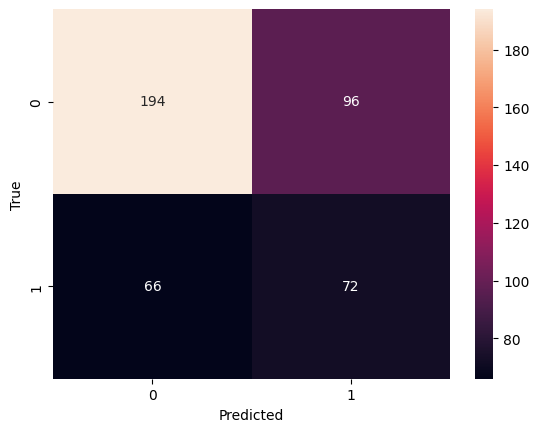

In [60]:
cm = confusion_matrix(predictions.label_ids, preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Persisting Results

In [61]:
eval_results_dir = f"./results/{WANDB_RUN_NAME}"
os.makedirs(eval_results_dir, exist_ok=True)

**Step-1: Locally**

In [62]:
report.to_csv(os.path.join(eval_results_dir, "classification_report.csv"))

# Save Confusion Matrix 
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(eval_results_dir, "confusion_matrix.png"))
plt.close()

**Step-2: Wandb**

In [63]:
metrics_to_log = {
    "eval/accuracy": report.loc["accuracy", "f1-score"],
    "eval/f1_weighted": report.loc["weighted avg", "f1-score"],
    "eval/f1_class_0": report.loc["0", "f1-score"],
    "eval/f1_class_1": report.loc["1", "f1-score"],
    "eval/recall_class_0": report.loc["0", "recall"],
    "eval/recall_class_1": report.loc["1", "recall"]
}

wandb.log(metrics_to_log)
table = wandb.Table(dataframe=report)
wandb.log({
    "confusion_matrix": wandb.Image(os.path.join(eval_results_dir, "confusion_matrix.png"))
})
wandb.log({"classification_report": table})

In [64]:
wandb.finish()

eval/accuracy,▁▁▁
eval/f1,▁
eval/f1_class_0,▁▁
eval/f1_class_1,▁▁
eval/f1_weighted,▁▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/recall_class_0,▁▁
eval/recall_class_1,▁▁
eval/runtime,▁


# Baseline 

In [224]:
train_baseline_texts = (train_data_masked["question"] + " [SEP] " + train_data_masked["target_sentence"]).tolist()
test_baseline_texts = (test_data_masked["question"] + " [SEP] " + test_data_masked["target_sentence"]).tolist()

In [225]:
train_labels = train_data_masked["label"].tolist()
test_labels = test_data_masked["label"].tolist()

In [226]:
baseline_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

In [227]:
baseline_pipeline.fit(train_baseline_texts, train_labels)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [228]:
test_preds = baseline_pipeline.predict(test_baseline_texts)
report = pd.DataFrame(classification_report(test_labels, test_preds, output_dict=True)).transpose()
display(report)

,precision,recall,f1-score,support
0,0.675532,0.437931,0.531381,290.000000
1,0.320833,0.557971,0.407407,138.000000
accuracy,0.476636,0.476636,0.476636,0.476636
macro avg,0.498183,0.497951,0.469394,428.000000
weighted avg,0.561166,0.476636,0.491408,428.000000
